# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\anjineyulu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%%time
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)
Wall time: 899 ms


In [5]:
%%time
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

Wall time: 5.8 s


In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
%%time
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Wall time: 1.95 ms


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[10]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[15]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[49]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Let's put in this way.  Flies stay on these traps and left.  It looks like a safe island to flies.
Ineffective and worthless. I bought this product for indoors and two other outdoor fly traps.  The outdoor traps worked immediately and I have noticed less flies in my home from my backdoor over the past week.  However, this indoor trap has caught zero flies yet over one week, while the outdoor traps have caught a combined 75-100.  I get excited looking at the trap thinking a fly was caught, but then realize that is the picture of a fly instead:-(.  Don't waste your money on this product.
We love nylabones around our home. Our two goldens must have the durable nylabone as t

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
Let's put in this way.  Flies stay on these traps and left.  It looks like a safe island to flies.
Ineffective and worthless. I bought this product for indoors and two other outdoor fly traps.  The outdoor traps worked immediately and I have noticed less flies in my home from my backdoor over the past week.  However, this indoor trap has caught zero flies yet over one week, while the outdoor traps have caught a combined 75-100.  I get excited looking at the trap thinking a fly was caught, but then realize that is the picture of a fly instead:-(.  Don't waste your money on this product.
We love nylabones around our home. Our two goldens must have the durable nylabone as t

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Ineffective and worthless. I bought this product for indoors and two other outdoor fly traps.  The outdoor traps worked immediately and I have noticed less flies in my home from my backdoor over the past week.  However, this indoor trap has caught zero flies yet over one week, while the outdoor traps have caught a combined 75-100.  I get excited looking at the trap thinking a fly was caught, but then realize that is the picture of a fly instead:-(.  Do not waste your money on this product.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Ineffective and worthless I bought this product for indoors and two other outdoor fly traps The outdoor traps worked immediately and I have noticed less flies in my home from my backdoor over the past week However this indoor trap has caught zero flies yet over one week while the outdoor traps have caught a combined 75 100 I get excited looking at the trap thinking a fly was caught but then realize that is the picture of a fly instead Do not waste your money on this product 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:30<00:00, 2910.34it/s]


In [25]:
preprocessed_reviews[15]

'ineffective worthless bought product indoors two outdoor fly traps outdoor traps worked immediately noticed less flies home backdoor past week however indoor trap caught zero flies yet one week outdoor traps caught combined get excited looking trap thinking fly caught realize picture fly instead not waste money product'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

# [4] Featurization

In [26]:
final['clean_text']=preprocessed_reviews

In [27]:
final['clean_text'].head(5)

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
Name: clean_text, dtype: object

In [28]:
final=final.sort_values('Time',ascending=True)

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final['clean_text'], final['Score'], random_state = 0, test_size = 0.2, shuffle = False)
x_tr, x_cv, y_tr, y_cv = train_test_split(x_train, y_train, random_state = 0, test_size = 0.25, shuffle = False)
# here we split the train data into train and cross validate

In [30]:
len(x_cv)

17555

In [31]:
len(x_tr)

52663

In [32]:
len(x_test)

17555

In [33]:
final['clean_text'].shape

(87773,)

## [4.1] BAG OF WORDS

In [37]:
%%time
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_x_train = count_vect.transform(x_tr)     #  y_tr
final_counts_x_crossval = count_vect.transform(x_cv) # y_cv
final_counts_x_test = count_vect.transform(x_test)
print("the type of count vectorizer ",type(final_counts_x_test))
print("the shape of out text BOW vectorizer ",final_counts_x_test.get_shape())
print("the number of unique words ", final_counts_x_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (17555, 49074)
the number of unique words  49074
Wall time: 16.6 s


In [38]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
k = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(final_counts_x_train,y_tr)
    pred = knn.predict_proba(final_counts_x_train)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred)
    print("AUC score for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
print('*'*50, '\n')


AUC score for K 5 is  0.8968510799021662
AUC score for K 10 is  0.8467154230243177
AUC score for K 15 is  0.8199419658229531
AUC score for K 21 is  0.7996385558649094
AUC score for K 31 is  0.7799982859692768
AUC score for K 41 is  0.7679458891108661
AUC score for K 51 is  0.7585803205544527
************************************************** 

Wall time: 35min 25s


In [39]:
%%time
# Using for loop to get the K.
# Train data: train and cv
# Predicting: cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc
auc_score = []

a = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(final_counts_x_train,y_tr)
    pred = knn.predict_proba(final_counts_x_crossval)[:,1]

# Evaluate AUC score
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for K", i, "is ", auc_cv)
    auc_score.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score]
print('*'*50, '\n')


AUC score for K 5 is  0.6662097756025042
AUC score for K 10 is  0.6835594708123524
AUC score for K 15 is  0.6888585429836415
AUC score for K 21 is  0.6882916045528856
AUC score for K 31 is  0.6911101554205435
AUC score for K 41 is  0.6944313058541838
AUC score for K 51 is  0.6932855223697322
************************************************** 

Wall time: 11min 24s


([<matplotlib.axis.YTick at 0x25729e48>,
 <a list of 21 Text yticklabel objects>)

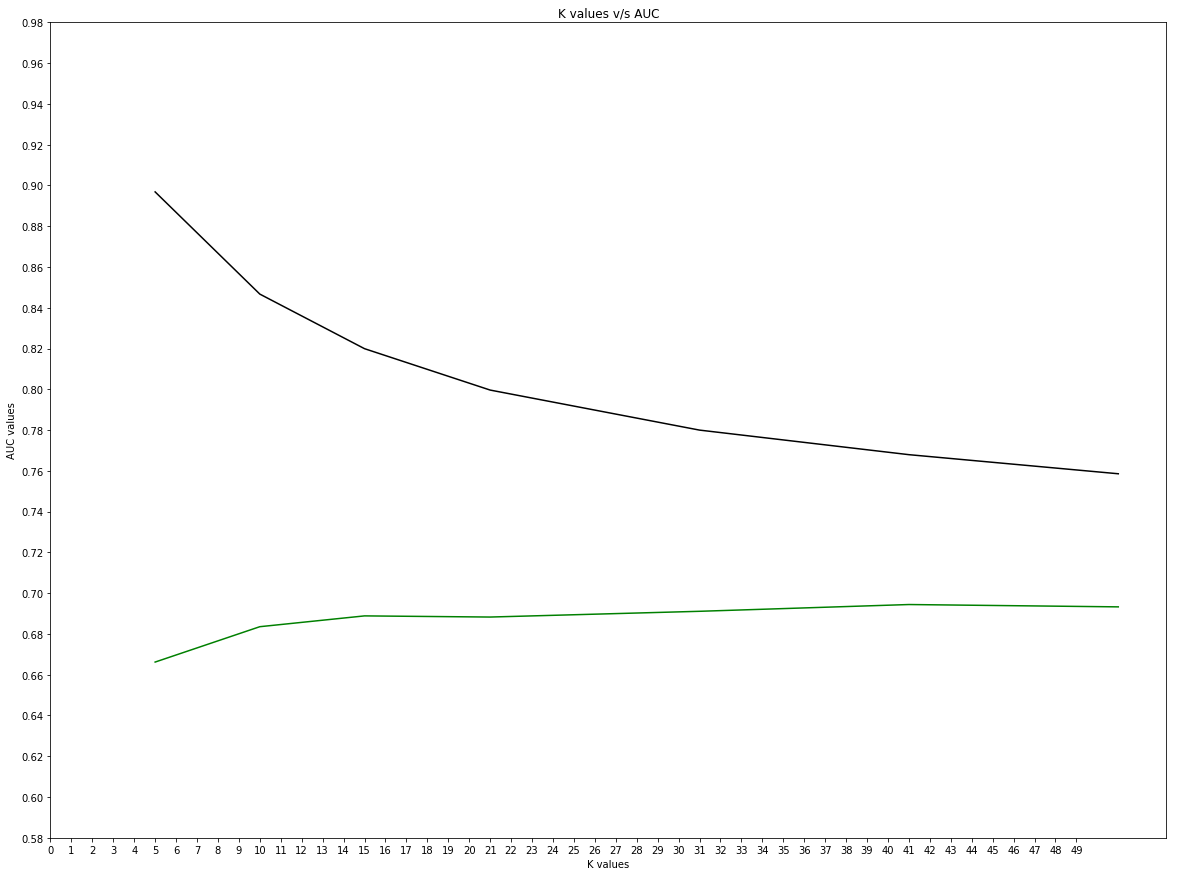

In [40]:

plt.figure(figsize = (20,15))
plt.plot(k, auc_cv,color='green')




plt.plot(k, auc_tr,  color = 'black')


plt.xlabel("K values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
plt.xticks(np.arange(0,50,1))
plt.yticks(np.arange(0.58,1,0.02))

In [41]:
best_k=51

In [42]:
knn = KNeighborsClassifier(n_neighbors = 51) 
knn_fit = knn.fit(final_counts_x_train,y_tr) 
prediction = knn_fit.predict(final_counts_x_test)

In [43]:
final_counts_x_test.shape

(17555, 49074)

In [44]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("accuracy score")
print(accuracy_score(y_test,prediction))



accuracy score
0.838279692395329


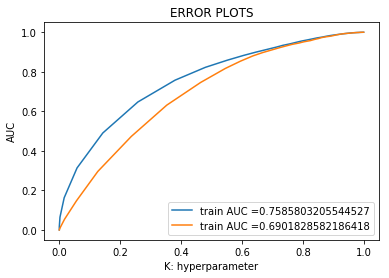

Train confusion matrix
[[  574  7451]
 [  388 44250]]
Test confusion matrix
[[  238  2676]
 [  163 14478]]


In [45]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(final_counts_x_train, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, neigh.predict_proba(final_counts_x_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(final_counts_x_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(final_counts_x_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(final_counts_x_test)))

In [46]:
#Reference:http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, prediction)
print(cm)


[[  238  2676]
 [  163 14478]]


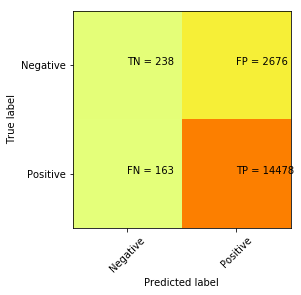

In [47]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


## [4.2] Bi-Grams and n-Grams.

In [48]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [51]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_tr)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)


final_tf_idf_tr = tf_idf_vect.transform(x_tr)
final_tf_idf_cv = tf_idf_vect.transform(x_cv)
final_tf_idf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(final_tf_idf_tr))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_tr.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew', 'able drink']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (52663, 31166)
the number of unique words including both unigrams and bigrams  31166


In [52]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc
auc_score = []
# Using for loop to get the K.
# Train data: train and cv
# Predicting: cv
a = [5,11,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(final_tf_idf_tr,y_tr)
    pred = knn.predict_proba(final_tf_idf_cv)[:,1]

# Evaluate AUC score
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for K", i, "is ", auc_cv)
    auc_score.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score]
print('*'*50, '\n')


AUC score for K 5 is  0.492943111599473
AUC score for K 10 is  0.49793658763211984
AUC score for K 15 is  0.5020672483477594
AUC score for K 21 is  0.5043605932286852
AUC score for K 31 is  0.5097227758891684
AUC score for K 41 is  0.510629920479275
AUC score for K 51 is  0.5104937431935601
************************************************** 



In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
k = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(final_tf_idf_tr,y_tr)
    pred = knn.predict_proba(final_tf_idf_tr)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred)
    print("AUC score for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]
print('*'*50, '\n')


AUC score for K 5 is  0.8770211346408818
AUC score for K 10 is  0.7977959016520435
AUC score for K 15 is  0.7541729306254439
AUC score for K 21 is  0.7235442610050055
AUC score for K 31 is  0.6964844797170007
AUC score for K 41 is  0.6776957048316266
AUC score for K 51 is  0.6665580406674725
************************************************** 



([<matplotlib.axis.YTick at 0x46450cf8>,
 <a list of 20 Text yticklabel objects>)

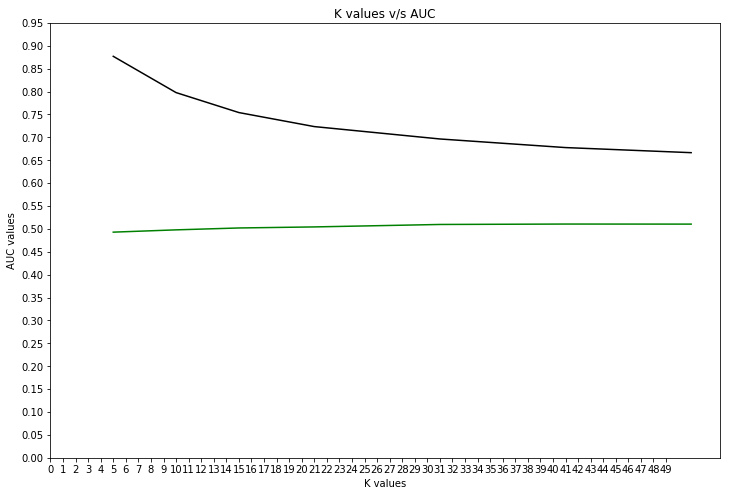

In [54]:
#reference:https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html
plt.figure(figsize = (12,8))
plt.plot(k, auc_cv,color='green')




plt.plot(k, auc_tr,  color = 'black')


plt.xlabel("K values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
plt.xticks(np.arange(0,50,1))
plt.yticks(np.arange(0,1,0.05))


In [55]:
best_k1=49

In [56]:
knn = KNeighborsClassifier(n_neighbors = best_k1) 
knn_fit = knn.fit(final_tf_idf_tr,y_tr) 
prediction = knn_fit.predict(final_tf_idf_test)


In [57]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("accuracy score")
print(accuracy_score(y_test,prediction))

accuracy score
0.834007405297636


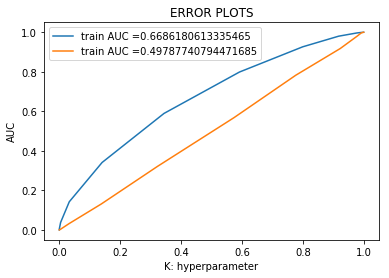

Train confusion matrix
[[    0  8025]
 [    0 44638]]
Test confusion matrix
[[    0  2914]
 [    0 14641]]


In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k1)
neigh.fit(final_tf_idf_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, neigh.predict_proba(final_tf_idf_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(final_tf_idf_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(final_tf_idf_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(final_tf_idf_test)))

In [63]:
#Reference:http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, prediction)
print(cm)


[[    0  2914]
 [    0 14641]]


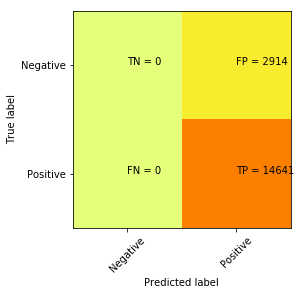

In [64]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


## [4.4] Word2Vec

In [34]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(x_tr,min_count=5,size=50, workers=4)
    #print(w2v_model.wv.most_similar('great'))
    print('='*50)
    #print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  27
sample words  ['b', 'o', 'u', 'g', 'h', 't', ' ', 'a', 'p', 'r', 'm', 'e', 'n', 'i', 'f', 's', 'd', 'l', 'c', 'y', 'w', 'v', 'z', 'k', 'q', 'x', 'j']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [68]:
len(x_tr)

52663

In [69]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_tr): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|███████████████████████████████████| 52663/52663 [01:44<00:00, 506.37it/s]


52663
50


In [70]:
len(sent_vectors_tr)

52663

In [71]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████| 17555/17555 [00:41<00:00, 419.57it/s]


17555
50


In [72]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(x_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 17555/17555 [00:48<00:00, 360.52it/s]


17555
50


In [73]:
# Using for loop to get the K.
# Train data: train and cv
# Predicting: cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc
auc_score = []

a = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(sent_vectors_tr,y_tr)
    pred = knn.predict_proba(sent_vectors_cv)[:,1]

# Evaluate AUC score
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for K", i, "is ", auc_cv)
    auc_score.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score]
print('*'*30, '\n')


AUC score for K 5 is  0.5628894893418592
AUC score for K 10 is  0.5812302358140615
AUC score for K 15 is  0.5905816974710936
AUC score for K 21 is  0.5980228195977886
AUC score for K 31 is  0.6134186649212529
AUC score for K 41 is  0.6172015229443534
AUC score for K 51 is  0.6231922028924753
****************************** 



In [74]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc

auc_score_tr = []
k = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(sent_vectors_tr,y_tr)
    pred = knn.predict_proba(sent_vectors_tr)[:,1]
    
    auc_tr = roc_auc_score(y_tr, pred)
    print("AUC score for K", i, "is ", auc_tr)
    auc_score_tr.append(auc_tr)
# Get the best k value and plot it

auc_tr = [x for x in auc_score_tr]

AUC score for K 5 is  0.8467679424331336
AUC score for K 10 is  0.782457240307247
AUC score for K 15 is  0.7537285137245986
AUC score for K 21 is  0.73540560624834
AUC score for K 31 is  0.7195372814942328
AUC score for K 41 is  0.7111760539858263
AUC score for K 51 is  0.7061716356110262


([<matplotlib.axis.YTick at 0x64073160>,
 <a list of 20 Text yticklabel objects>)

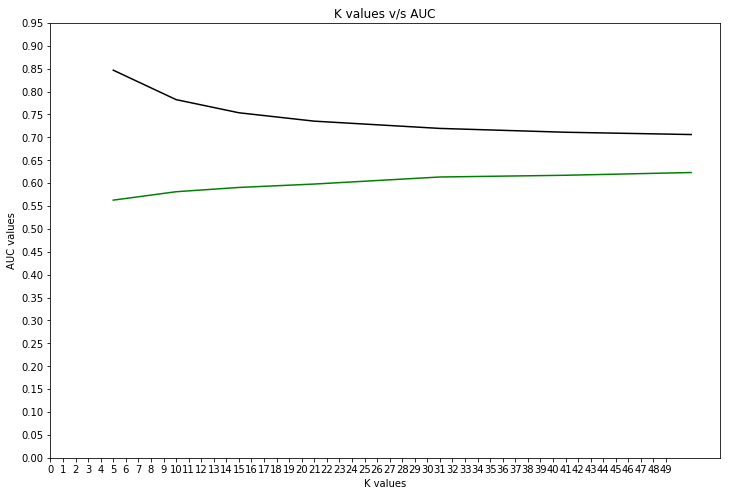

In [75]:

plt.figure(figsize = (12,8))
plt.plot(k, auc_cv,color='green')




plt.plot(k, auc_tr,  color = 'black')


plt.xlabel("K values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
plt.xticks(np.arange(0,50,1))
plt.yticks(np.arange(0,1,0.05))
plt.xticks(np.arange(0,50,1))
plt.yticks(np.arange(0,1,0.05))


In [76]:
best_k2=49

In [77]:
knn = KNeighborsClassifier(n_neighbors =best_k2) 
knn_fit = knn.fit(sent_vectors_tr,y_tr) 
prediction = knn_fit.predict(sent_vectors_test)


In [78]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("accuracy score")
print(accuracy_score(y_test,prediction))



accuracy score
0.8338934776416975


In [79]:
from sklearn.metrics import roc_curve, auc

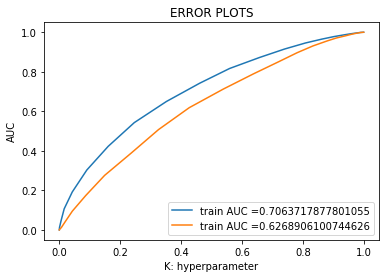

Train confusion matrix
[[    8  8017]
 [    5 44633]]
Test confusion matrix
[[    2  2912]
 [    4 14637]]


In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k2)
neigh.fit(sent_vectors_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, neigh.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(sent_vectors_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

In [81]:
#Reference:http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, prediction)
print(cm)


[[    2  2912]
 [    4 14637]]


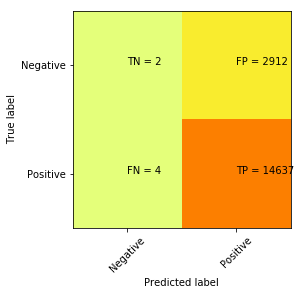

In [82]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


#### [4.4.1.2] TFIDF weighted W2v

In [37]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_tr = model.fit_transform(x_tr)
tf_idf_matrix_test = model.transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 52663/52663 [2:55:22<00:00,  3.90it/s]


In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 17555/17555 [1:09:57<00:00,  4.54it/s]


In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(x_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [45:38<00:00,  6.41it/s]


In [41]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc
auc_score = []

k = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(tfidf_sent_vectors_tr,y_tr)
    pred = knn.predict_proba(tfidf_sent_vectors_cv)[:,1]

# Evaluate AUC score
    auc_cv = roc_auc_score(y_cv, pred)
    print("AUC score for K", i, "is ", auc_cv)
    auc_score.append(auc_cv)
# Get the best k value and plot it

auc_cv = [x for x in auc_score]


AUC score for K 5 is  0.5
AUC score for K 10 is  0.5
AUC score for K 15 is  0.5
AUC score for K 21 is  0.5
AUC score for K 31 is  0.5
AUC score for K 41 is  0.5
AUC score for K 51 is  0.5


In [49]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, auc
auc_score = []

k = [5,10,15,21,31,41,51]

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i, algorithm ='brute')
    knn = knn.fit(tfidf_sent_vectors_tr,y_tr)
    pred = knn.predict_proba(tfidf_sent_vectors_tr)[:,1]

# Evaluate AUC score
    auc_tr = roc_auc_score(y_tr pred)
    print("AUC score for K", i, "is ", auc_tr)
    auc_score.append(auc_tr)
# Get the best k value and plot it

auc_tr = [x for x in auc_score]


AUC score for K 5 is  0.5
AUC score for K 10 is  0.5
AUC score for K 15 is  0.5
AUC score for K 21 is  0.5
AUC score for K 31 is  0.5
AUC score for K 41 is  0.5
AUC score for K 51 is  0.5


([<matplotlib.axis.YTick at 0x1e91960e9e8>,
 <a list of 20 Text yticklabel objects>)

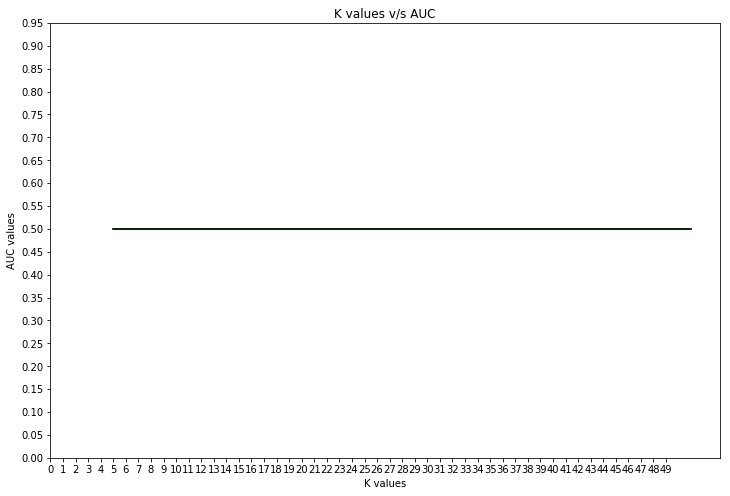

In [51]:

plt.figure(figsize = (12,8))
plt.plot(k, auc_cv,color='green')




plt.plot(k, auc_tr,  color = 'black')


plt.xlabel("K values")
plt.ylabel("AUC values")
plt.title("K values v/s AUC")
plt.xticks(np.arange(0,50,1))
plt.yticks(np.arange(0,1,0.05))


In [52]:
best_k3=25

In [53]:
knn = KNeighborsClassifier(n_neighbors =best_k3) 
knn_fit = knn.fit(tfidf_sent_vectors_tr,y_tr) 
prediction = knn_fit.predict(tfidf_sent_vectors_test)


In [55]:
from sklearn.metrics import accuracy_score,confusion_matrix
print("accuracy score")
print(accuracy_score(y_test,prediction))

print("Shown below is the confusion matrix")
print(confusion_matrix(y_test,prediction))

#now we will create a confusion matrix


accuracy score
0.834007405297636
Shown below is the confusion matrix
[[    0  2914]
 [    0 14641]]


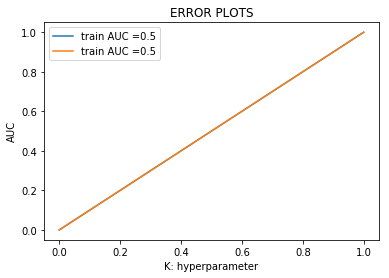

Train confusion matrix
[[    0  8025]
 [    0 44638]]
Test confusion matrix
[[    0  2914]
 [    0 14641]]


In [56]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k3)
neigh.fit(tfidf_sent_vectors_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr, neigh.predict_proba(tfidf_sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_tr, neigh.predict(tfidf_sent_vectors_tr)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))

In [57]:
#Reference:http://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test, prediction)
print(cm)


[[    0  2914]
 [    0 14641]]


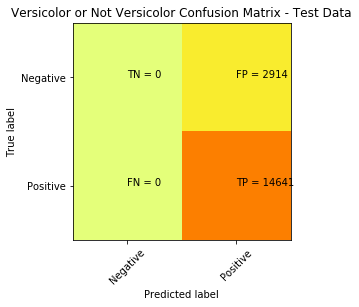

In [58]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
# Please write all the code with proper documentation

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Please compare all your models using Prettytable library

In [61]:
#http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S.No", "Featurization", "K","auc sores"]

x.add_row([1,"Bag of Words",51,83.82])
x.add_row([2,"Tf-Idf", 49,83.40])
x.add_row([3, "Avg Word2Vec", 49,83.38])
x.add_row([4, "Tf-Idf Word2Vec", 25,83.40])
x.add_row([5,"Bag of Words using kd-tree",51,86.25])
x.add_row([6,"Tf-Idf using kd-tree",10,85.6])
x.add_row([7, "Avg Word2Vec using kd-tree",51,86.2])
x.add_row([8, "Tf-Idf Word2Vec using kd-tree",25,86.2])

In [62]:
print(x)

+------+-------------------------------+----+-----------+
| S.No |         Featurization         | K  | auc sores |
+------+-------------------------------+----+-----------+
|  1   |          Bag of Words         | 51 |   83.82   |
|  2   |             Tf-Idf            | 49 |    83.4   |
|  3   |          Avg Word2Vec         | 49 |   83.38   |
|  4   |        Tf-Idf Word2Vec        | 25 |    83.4   |
|  5   |   Bag of Words using kd-tree  | 51 |   86.25   |
|  6   |      Tf-Idf using kd-tree     | 10 |    85.6   |
|  7   |   Avg Word2Vec using kd-tree  | 51 |    86.2   |
|  8   | Tf-Idf Word2Vec using kd-tree | 25 |    86.2   |
+------+-------------------------------+----+-----------+


It is observed that K-nn algorithm does not work very well on the data 

Auc Scores for both brute force algorithm and kd tree algorithm are almost similar. Both gave similiar auc values

Understood why knn is not widely used in the industry